# Progetto DL24: YesWeKAN

Nel notebook **Introduzione KAN** abbiamo spiegato nel dettaglio le idee alla base del nostro progetto, le motivazioni che hanno guidato la nostra scelta e abbiamo introdotto l'argomento con un aporoccio divulgativo e volto alla comprensione dell'argomento da parte di chi si affacci per la prima volta alla scoperta delle reti KAN.

Con questo notebook ci proponiamo invece di presentare il cuore del nostro lavoro che parte dalle operazioni di preprocessing e trattamento dei dati nel dataset e arriva alla trasparenza algoritmica passando per la definizione delle architetture d'interesse per il lavoro e il loro confronto prima in termini prestazionali e poi sotto l'aspetto dell'equità algoritmica.

Tutti i modelli presentati in questo notebook sono stati definiti e ottimizzati mediante delle operazioni di tuning eseguite e descritte nel notebook **Tuning degli iperparametri**

### Importazione librerie

Come operazione preliminare importiamo le **librerie** che saranno utilizzate in questo notebook, per chiarezza le abbiamo divise in gruppi:

- Librerie di **sistema**: intriducono funzionalità a basso-medio livello
- Librerie per l'utilizzo di **Matrici, dataframe e tensori**
- Librerie per l'utilizzo di **Modelli di Machine Learning e Deep Learning**
- Librerie **grafiche**: introducono funzioni per la stampa di tabelle, grafici e strumenti di visualizzazione dei risultati
- Librerie **custom**: Introducono i livelli DenseKAN e di funzioni di utilità

In [16]:
# Librerie di sistema
import os
import random
import base64
import datetime

# Array, dataframe e tensori
import numpy as np
import pandas as pd
import tensorflow as tf

# Modelli ML & DL
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.utils import check_random_state
from lime.lime_tabular import LimeTabularExplainer

# Librerie grafiche
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
import matplotlib.pyplot as plt # fornisce funzioni per generare grafici
import seaborn as sns
import networkx as nx # fornisce funzioni per la creazione di grafi

# Librerie custom
import utility as ut
from tfkan import DenseKAN

⚠️ Per rendere l'esperimento ripetibile, andiamo ad *impostare il seme casuale* di tutte le librerie che fanno utilizzo della casualità nell'elaborazione, in modo che queste vadano a generare sequenzialmente gli stessi valori ad ogni riavvio del notebook (o meglio, del kernel Python che esegue il notebook). 

Ci teniamo a far notare che in questo modo, nel caso si esegua più volte la stessa cella, essa probabilmente non presenterà gli stessi risultati, andando a *compromettere la riproducibilità* di tutte le celle di codice a seguire. Per riportare il flusso di esecuzione ad uno stato di riproducibilità sarà necessario *riavviare il kernel* Python del notebook. 

La scelta di impostare il seed e non ogni volta il random state è dovuta al fatto che per alcune librerie risultava difficoltoso se non impossibile impostare ogni random state, oltre ad un fattore di comodità maggiore ed un fattore di rischio minore nella scrittura del codice.

In [17]:
# Valore del seme causale
seed_value = 0

# Impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Controllo che il seme sia stato correttamente impostato
check_random_state(seed_value)

RandomState(MT19937) at 0x1E828A46440

# Dataset

## Scelta del dataset

💱 Visto che il **cambio radicale** nell'architettura avviene al **livello degli archi** tra input e output di un qualsiasi livello, è possibile definire tutti i principali tipi di livelli visti durante il corso: non solo i livelli densamente connessi, ma anche convolutivi, ricorrenti, e perfino transformer. Tuttavia in questo progetto, dovendo implementare autonomamente questo nuovo tipo di rete, abbiamo optato per usare dei **livelli densamente connessi**.

🩺 Per la scelta del dataset, abbiamo pensato di non focalizzarci sulle possibili applicazioni citate nel paper, ma di approfondire qualche altro settore. Vista la maggiore spiegabilità delle reti KAN rispetto ad una rete MLP, abbiamo scelto un dataset in **campo medico**, in cui la spiegabilità e la trasperanza algoritmica sono fattori determinanti non solo per il personale medico, che ha -anche- il compito di valutare le decisioni della rete, ma anche per i pazienti, in modo che possano prendere coscienza dei motivi dietro le scelte mediche.

🏥 Il dataset che abbiamo scelto, dopo aver guardato le opzioni disponibili su [Kaggle](https://www.kaggle.com/), è [Hospital Length of Stay Dataset Microsoft](https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft). Qui il task è di **regressione**, e consiste nello stimare i giorni di ricovero di un paziente, conoscendo diversi dati personali e medici di quest'ultimo.

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [3]:
# Variabili del dataset
DATASET_NAME = 'LengthOfStay'
FEATURES = [ # Nomi feature accorciati (per migliorare la visualizzazione nei grafici)
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

# Numero feature usate dal modello
N_FEATURES = len(FEATURES)

# Definisce i colori da usare per le barre
COLORS = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  

# Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

# Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

## Analisi del dataset

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record.

Per farlo utilizziamo la classe `FeatureStatisticsGenerator` che produce un risultato in formato HTML dunque visualizzabile sul notebook.

In [4]:
# Genera statistiche sul dataset
fsg = FeatureStatisticsGenerator()
dataframes = [ {'table': df, 'name': DATASET_NAME}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

# Impostazioni per la visualizzazione
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

# Mostra analisi grafica
display(HTML(html)) 

c:\Users\fraca\miniconda3\envs\DL\Lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori.

Notiamo inoltre che anche i valori target seguono una distribuzione sbilanciata in cui sono molto più frequenti i valori minori di quello medio.

## Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che sono presenti degli attributi categorici come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow, infatti ricordiamo che le reti, essendo funzioni differenziabili, possono trattare esclusivamente tensori numerici. Dobbiamo dunque codificare tutti i valori in forma rigorosamente numerica.

Gli attributi che devono essere ricodificati sono:

- **eid**: è un identificativo univoco del record nel dataset; non porta alcuna informazione, per cui non lo consideriamo.
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare la data di fine ricovero, in quanto non è un'informazione che ci dovrebbe essere nota al momento della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

Dopo aver eliminato le colonne che non consideriamo, ma prima di trasformare dati categorici in numerici, ci salviamo una copia del dataset per i modelli di ML, che possono gestire anche dati categorici.

In [5]:
# Rimuove la colonna "discharged"
df.drop("discharged", axis=1, inplace=True) 

# Rimuove la colonna "eid"
df.drop("eid", axis=1, inplace=True)

# Codifica del 5+ in 5 in rcount
keys = sorted(df["rcount"].unique())
values = range(len(keys))
df.replace({"rcount": dict(zip(keys, values))}, inplace=True)

# Codifica delle date come numeri interi progressivi
keys = df["vdate"].unique()
values = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in keys]
df.replace({"vdate": dict(zip(keys, values))}, inplace=True)

# Codifica del genere come intero binario
keys = df["gender"].unique()
values = range(len(keys))
df.replace({"gender": dict(zip(keys, values))}, inplace=True)

# Codifica dei facid come numeri interi progressivi
keys = df["facid"].unique()
values = range(len(keys))
df.replace({"facid": dict(zip(keys, values))}, inplace=True)

Come sappiamo, le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati.
Eseguiamo quindi una normalizzazione MinMax, che porterà tutti i valori nell'intervallo [0, 1] e per farlo utilizzeremo la funzione `standardize`, definita nella nostra libreria custom.

In [6]:
# Standardizzazione degli attributi del dataset
df = df.astype(float)
df.iloc[:, :-1] = ut.standardize(df.iloc[:, :-1])

## Separazione del dataset

A questo punto il dataset ha solamente valori numerici. Separiamo il training set dal test set; in questo passaggio non introduciamo il set di validazione in quanto nelle celle immediatamente successive a queste predisporremo l'addestramento dei modelli con il metodo **k-fold**.

Dopo esserci salvati in alcuni file csv le partizioni del dataset separate, convertiamo il dataframe in un tensore Tensorflow.

In [7]:
# Definizione rapporto di split
TEST_RATIO = 0.20

# Separazione train, test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=TEST_RATIO)

# Creazione dei dataset di train, test in csv
x_train.to_csv("datasets/x_train.csv", index=False)
y_train.to_csv("datasets/y_train.csv", index=False)
x_test.to_csv("datasets/x_test.csv", index=False)
y_test.to_csv("datasets/y_test.csv", index=False)

# Conversione del dataframe in tensore
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

# Stampa le dimensioni dei nuovi dataset creati
print("train: ", x_train.shape," test: ",  x_test.shape)

train:  (80000, 25)  test:  (20000, 25)


### K-Fold

Il metodo di partizione **k-fold** consiste nel suddividere i dati del train set (quelli di cui disponiamo per l'addestramento) in $k$ partizioni di dimensione fissa e suddividere l'addestramento in altrettante fasi; durante ogni fase l'addestramento viene eseguito utilizzando $k - 1$ partizioni per il training e quella rimanente per la validazione.

Questa pratica viene utilizzata per evitare che l'addestramento dei modelli sia troppo dipendente da una specifica partizione train-validation-test, infatti abbiamo notato che al variare di questa, anche le prestazioni subivano delle variazioni, talvolta piuttosto significative. Il k-fold conferisce all'addestramento robustezza rispetto alla variabilità introdotta dal partizionamento.

Nel nostro caso utilizziamo $k = 4$ dunque 4 partizioni (o fold) perché riteniamo che questo possa essere un buon compromesso che assicura allo stesso tempo una buona variabilità nelle partizioni e tempistiche di addestramento accettabili.

In [8]:
# Definizione degl indici di training e validation set
kfold = KFold(n_splits=4, shuffle=True, random_state=0)
train_val_indices = list(kfold.split(x_train))

# Definizione delle liste di training e validation set
x_train_fold_list = []
y_train_fold_list = []
x_val_fold_list = []
y_val_fold_list = []
for train_indices, val_indices in train_val_indices:
    x_train_fold_list.append(tf.gather(x_train, train_indices))
    x_val_fold_list.append(tf.gather(x_train, val_indices))
    y_train_fold_list.append(tf.gather(y_train, train_indices))
    y_val_fold_list.append(tf.gather(y_train, val_indices))

training_validation_set = list(zip(x_train_fold_list, y_train_fold_list, x_val_fold_list, y_val_fold_list))

Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte dalle reti fully connected agli algoritmi più tradizionali.

Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Utilizzeremo le metriche tipiche di un task di regressione cioè **MSE**, **MAE** e **RMSE**.

Definiamo inoltre alcuni parametri relativi all'addestramento dei modelli che saranno utilizzati nei metodi `compile` e `fit`. Un particolare che risalta è l'iperparametro **EPOCHS_PER_FOLD** che moltiplicato per il numero di fold $k$ è uguale al numero totale di epoche di addestramento.

In [25]:
# Lista di metriche necessarie per valutare le performance 
METRICS_NAME = {"mean_absolute_error":"mae", "mean_squared_error":"mse", "root_mean_squared_error":"rmse", "r2_score": "r2_score"}
METRICS = [tf.keras.metrics.get(metric_name) for metric_name in METRICS_NAME]
for metric in METRICS:
    metric.name = METRICS_NAME[metric.name]

# Costanti dei modelli
BATCH_SIZE = 128
EPOCHS_PER_FOLD = 10
LOSS = "mse"

# Lista dei modelli addestrati e delle loro performance
elenco_modelli = {}
histories = {}

La scelta di utilizzare il metodo k-fold ci pone la questione di come visualizzare l'andamento delle metriche e della funzione di loss con il progredire dell'addestramento sui diversi fold. Il metodo `fit` accetta infatti una sola partizione train-validation dunque dobbiamo eseguirlo $k$ volte e salvarci in un'unica lista tutto lo storico delle meriche che monitoriamo.

La funzione `training` restituisce un dizionario che associa alle metriche del modello delle liste contenenti lo storico (history) dei loro valori durante l'addestramento.

Per quanto riguarda l'addestramento dei modelli di ML tradizionale abbiamo scritto la funzione `trainingML` che semplicemente esegue l'addestramento su ciascun fold per un totale di $k$ iterazioni.

In [23]:
# Funzione per l'addestramento dei modelli DL
def training(model) -> dict:
    total_history = {}

    # Training per ogni fold
    for fold, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(training_validation_set):
        print(f"Fold {fold}")

        history = model.fit(x_train_fold, y_train_fold, epochs=EPOCHS_PER_FOLD, batch_size=BATCH_SIZE, validation_data=(x_val_fold, y_val_fold), verbose=1)

        # Memorizzazione della storia del training
        for key, value in history.history.items():
            if key not in total_history:
                total_history[key] = value
            else:
                total_history[key] += value

    return total_history

# Funzione per l'addestramento dei modelli DL
def trainingML(model):
    for x_train_fold, y_train_fold, _, __ in training_validation_set:
        model.fit(x_train_fold, y_train_fold)

# Definizione architettura KAN Classica
Come spiegato nell'articolo su cui ci basiamo e ribadito nel notebook **Tutorial**, ogni livello $l$ di una rete KAN contiene $inputs_l$ * $units_l$ funzioni spline, ognuna delle quali ha formula $$\phi(x) = w_bb(x) + w_s\sum{c_iB_i}$$

Il numero totale dei parametri del livello si ottiene sommando:
- I coefficienti $w_s$, uno per ogni spline; totale = $inputs_l$ * $units_l$
- I coefficienti $c_i$, uno per ogni funzione basis, il cui numero per ogni spline è uguale a $grid\_size - spline\_order - 1$; totale = $inputs_l$ * $units_l$ * $\#B_i$
- I bias $w_b$, uno per ogni spline; totale = $inputs_l$ * $units_l$

Nonostante il conteggio dei parametri sembri maggiore rispetto a quello di un MLP vedremo che nel complesso ne serviranno molti meno per comparare e battere le prestazioni di quest'ultimo.

In [26]:
# Creazione del modello KAN con parametri del tuning
kan = tf.keras.models.Sequential([
    DenseKAN(16, grid_range=[-1, 1], grid_size=20, spline_order=2),
    DenseKAN(4, grid_range=[-5, 5], grid_size=32, spline_order=3),
    DenseKAN(8, grid_range=[-4.9, 4.9], grid_size=22, spline_order=3),
    DenseKAN(1)
])
# Build del modello (chiamata necessaria a definire la dimensione dell'input quando si utilizza l'API Sequential)
kan.build(input_shape=(None, N_FEATURES))
kan.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.011774913804863748), loss=LOSS, metrics=METRICS)  # Compilazione del modello (iperparamentri ottimizzati in fase di tuning)

# Stampa del sommario
kan.summary()

# Training modello e salvataggio performance
histories['KAN'] = training(kan)
elenco_modelli['KAN'] = kan

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_8 (DenseKAN)          │ (None, 16)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_9 (DenseKAN)          │ (None, 4)              │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_10 (DenseKAN)         │ (None, 8)              │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_11 (DenseKAN)         │ (None, 1)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,208 (39.88 KB)

 Trainable params: 10,208 (39.88 KB)

 Non-trainable params: 0 (0.00 B)

Fold 0
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3224 - mae: 1.0679 - mse: 2.3224 - r2_score: 0.5885 - rmse: 1.4575 - val_loss: 0.6134 - val_mae: 0.6170 - val_mse: 0.6134 - val_r2_score: 0.8889 - val_rmse: 0.7832
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5370 - mae: 0.5246 - mse: 0.5370 - r2_score: 0.9046 - rmse: 0.7327 - val_loss: 0.4276 - val_mae: 0.4629 - val_mse: 0.4276 - val_r2_score: 0.9225 - val_rmse: 0.6539
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4624 - mae: 0.4809 - mse: 0.4624 - r2_score: 0.9179 - rmse: 0.6799 - val_loss: 0.4987 - val_mae: 0.5269 - val_mse: 0.4987 - val_r2_score: 0.9097 - val_rmse: 0.7062
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4258 - mae: 0.4618 - mse: 0.4258 - r2_score: 0.9244 - rmse: 0.6524 - val_loss: 0.3581 - val_mae: 0.3991 - val_mse: 0.3581 - val_r2_score: 0.9351 - val_rmse: 0.5984
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3809 - mae: 0.4306 - mse: 

# Definizione architettura MLP Classica
A questo punto definiamo una classica **rete a livelli completamente connessi** MLP utilizzata molto frequentemente nelle architetture allo stato dell'arte.

Come sempre utilizziamo delle funzioni di attivazione ReLU nei livelli intermedi mentre, trattandosi di un task di regressione, l'ultimo livello avrà una sola unità di output e nessuna funzione di attivazione. Una particolarità da notare è l'utilizzo di un regolarizzatore, in questo caso basato sulla **norma L2**: abbiamo notato che l'introduzione di questo fattore stabilizza l'addestramento limitandone fluttuazioni a cui normalmente si assiste con l'avanzamento delle epoche.

In [27]:
# Creazione del modello MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(156, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.00027151975248047394)),
    tf.keras.layers.Dense(224, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0016076644854235774)),
    tf.keras.layers.Dense(216, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0004701808479158671)),
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00020462523238833736)),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000420656047032272)),
    tf.keras.layers.Dense(1)
])

mlp.build(input_shape=(None, N_FEATURES))
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006224065081134311), loss=LOSS, metrics=METRICS)

# Stampa sommario
mlp.summary()

# Training modello e salvataggio performance
histories['MLP'] = training(mlp)
elenco_modelli['MLP'] = mlp



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 156)            │         4,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        35,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 216)            │        48,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         4,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,429 (361.05 KB)

 Trainable params: 92,429 (361.05 KB)

 Non-trainable params: 0 (0.00 B)

Fold 0
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.6269 - mae: 0.7902 - mse: 1.7508 - r2_score: 0.6866 - rmse: 1.3201 - val_loss: 1.4903 - val_mae: 0.8578 - val_mse: 1.1955 - val_r2_score: 0.7834 - val_rmse: 1.0934
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3898 - mae: 0.7958 - mse: 1.1100 - r2_score: 0.8029 - rmse: 1.0535 - val_loss: 1.2408 - val_mae: 0.7700 - val_mse: 0.9967 - val_r2_score: 0.8194 - val_rmse: 0.9984
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1429 - mae: 0.6933 - mse: 0.9069 - r2_score: 0.8390 - rmse: 0.9522 - val_loss: 1.0344 - val_mae: 0.6560 - val_mse: 0.8221 - val_r2_score: 0.8511 - val_rmse: 0.9067
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9800 - mae: 0.6272 - mse: 0.7754 - r2_score: 0.8623 - rmse: 0.8805 - val_loss: 0.9409 - val_mae: 0.6212 - val_mse: 0.7582 - val_r2_score: 0.8627 - val_rmse: 0.8707
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8985 - mae: 0.6018 - mse: 0

# Definizione architerrura KAN-MLP 1 (Livelli misti)
Definiamo infine un'architettura **ibrida**, un mix tra KAN e MLP con l'idea di poter combinare in un'unica rete tutti i vantaggi di queste due.

Da un lato desideriamo l'accuratezza, il minor numero di parametri e la scalabilità di una KAN, dall'altra cerchiamo di ridurre i tempi di addestramento avvicinandoli a quelli comparativamente minori di un MLP.

Per quanto riguarda la spiegabilità, questa viene compromessa in maniera decisiva dalla presenza dei livelli Dense, infatti perdiamo completamente il controllo su quali valori entrano in input alle spline, e sebbene possiamo osservare la composizione delle funzioni, non sono spiegabili le trasformazioni dei valori in ingresso; per chiarire il concetto, sarebbe come se capissimo le operazioni che vengono fatte tra i dati, ma non sapessimo cosa quei dati rappresentano, quali elaborazioni hanno subito per arrivare alla forma che osserviamo.

In [28]:
# Creazione del modello KAN-MLP 1
kanmlp = tf.keras.models.Sequential([
    # DenseKAN(16),
    # Dense(64),
    # DenseKAN(6),
    Dense(64),
    DenseKAN(1)
])
kanmlp.build(input_shape=(None, N_FEATURES))
kanmlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=LOSS, metrics=METRICS)

# Stampa sommario
kanmlp.summary()

# Training modello e salvataggio performance
histories['KAN_MLP'] = training(kanmlp)
elenco_modelli['KAN_MLP'] = kanmlp

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_12 (DenseKAN)         │ (None, 1)              │           384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,048 (8.00 KB)

 Trainable params: 2,048 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Fold 0
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.9553 - mae: 0.8567 - mse: 1.7600 - r2_score: 0.6850 - rmse: 1.3244 - val_loss: 1.1829 - val_mae: 0.8232 - val_mse: 1.1829 - val_r2_score: 0.7857 - val_rmse: 1.0876
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1566 - mae: 0.8208 - mse: 1.1566 - r2_score: 0.7946 - rmse: 1.0753 - val_loss: 1.0757 - val_mae: 0.7905 - val_mse: 1.0757 - val_r2_score: 0.8051 - val_rmse: 1.0371
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0318 - mae: 0.7682 - mse: 1.0318 - r2_score: 0.8168 - rmse: 1.0157 - val_loss: 0.9178 - val_mae: 0.7201 - val_mse: 0.9178 - val_r2_score: 0.8337 - val_rmse: 0.9580
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8622 - mae: 0.6797 - mse: 0.8622 - r2_score: 0.8469 - rmse: 0.9284 - val_loss: 0.7765 - val_mae: 0.6342 - val_mse: 0.7765 - val_r2_score: 0.8593 - val_rmse: 0.8812
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7465 - mae: 0.6198 - mse: 0

# Definizione architettura Albero Decisionale
Introduciamo ora il primo modello basato sul Machine Learning tradizionale: un **albero decisionale di regressione**.

Come abbiamo fatto per le reti ad apprendimento automatico, anche in questo caso abbiamo assegnato gli iperparametri in seguito ad un tuning.
Uno dei motivi che ci ha spinto a optare per un albero è la possibilità di stampare a video una rappresentazione del modello in modo da poter visualizzare gli attributi utilizzati in fase di predizione.

Essendo l'albero un modello estremamente spiegabile, conoscere gli attributi che utilizza potrebbe darci una prima indicazione su quali siano i più significativi in termini di discriminazione delle istanze.

Tuttavia teniamo presente che i criteri utilizzati da un modello non danno nessuna indicazione su quelli utilizzati da un altro, in questo caso vogliamo più che altro avere un'idea di massima sull'importanza relativa degli attributi.

Come metrica per valutare questo modello utilizzeremo il Coefficiente di determinazione $R^2$ definito come $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} = 1 - \frac{SSR}{SST}$$ in cui 

- $SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ (Somma dei quadrati residui) quantifica la variabilità nelle predizioni del modello
- $SST = \sum_{i=1}^{n} (y_i - \bar{y}_i)^2$ (Somma dei quadrati totali) quantifica la "qualità" nelle predizioni in  termini di scostamento dal valore medio, infatti un regressore che predice sistematicamente il valore medio non è buono.

R² score: 0.8349726642662498


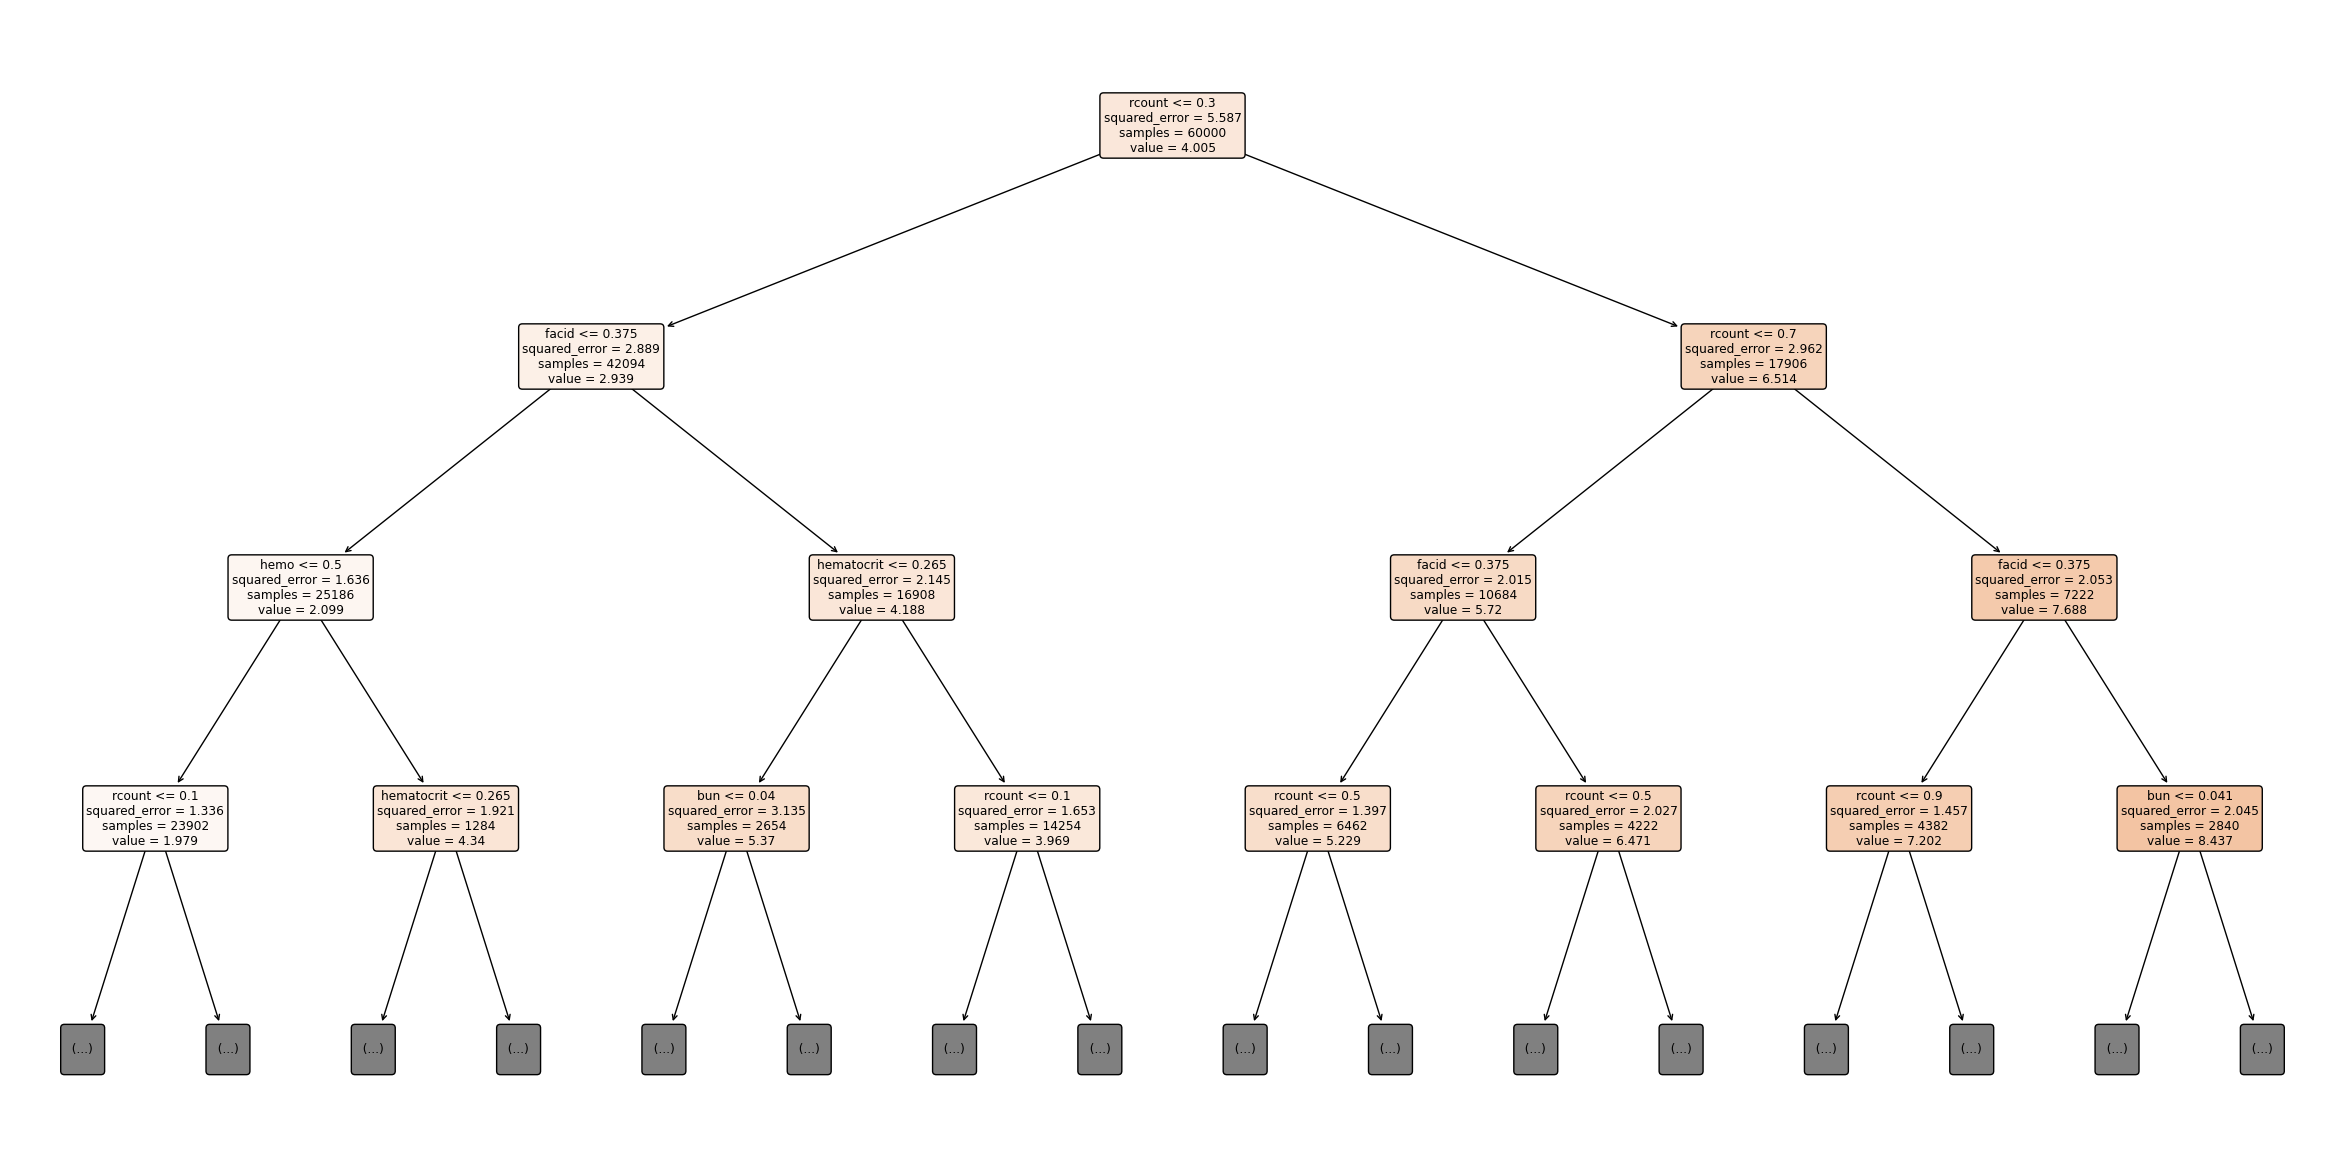

In [29]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(
    ccp_alpha=0.000000001,
    criterion='squared_error',
    max_depth=35,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=0,
    splitter='best'
)

# Addestramento
trainingML(tree)

# Aggiunge il modello alla lista modelli
elenco_modelli['TREE'] = tree

# Stampa lo score R^2 del modello
print(f"R² score: {tree.score(x_test, y_test)}")

# Disegna l'albero
plt.figure(figsize=(30,15))
plot_tree(tree, max_depth=3, filled=True, rounded=True, feature_names=FEATURES)
plt.show()

# Definizione architettura Random Forest
Come secondo approccio di Machine Learning tradizionale introduciamo una **Random Forest** di regressione; rispetto all'albero ci aspettiamo prestazioni migliori ma il prezzo da pagare (come spesso accade) sarà una minore trasparenza.

Anche in questo caso visualizziamo il $R^2$ score.

In [13]:
# Crea il modello della random forest
forest = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=35,
    max_features=1.0,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=250,
    random_state=0,
    verbose=0,
    warm_start=False
)

# Addestramento
trainingML(forest)

# Aggiunge il modello alla lista modelli
elenco_modelli['FOREST'] = forest

# Stampa lo score R^2 del modello
print(f"R² score: {forest.score(x_test, y_test)}")

R^2 score: 0.9215140416635426


# Definizione architettura Ensemble
Infine definiamo un modello di regressione **ensemble** composto da un albero decisionale, un Support Vector Regressor e un regressore bayesiano.

Per questo modello abbiamo sperimentato anche delle altre configurazioni, in particolare, valutando l'opportunità di introdurre il SVR al posto di un molto più semplice regressore lineare, abbiamo notato che a fronte di un notevole aumento delle tempistiche di addestramento, le metriche avevano miglioramenti intorno ai 10 punti percentuali.

In [98]:
# Crea il modello di ensemble
ensemble = VotingRegressor(
    estimators=[
    ('tree', DecisionTreeRegressor(
    ccp_alpha=0.000000001,
    criterion='squared_error',
    max_depth=35,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=0,
    splitter='best'
    )),        
    ('svm', SVR(kernel='rbf', C=10, epsilon=0.01, gamma=0.1, coef0=0.1, tol=0.001,cache_size=20)),
    ('bayes', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, tol=0.001, verbose=False))
    ],
    n_jobs=None,
    verbose=False,
    weights=None
)

# Addestramento
trainingML(ensemble)

# Aggiunge il modello alla lista modelli
elenco_modelli['ENSEMBLE'] = ensemble

print(f"R² score: {ensemble.score(x_test, y_test)}")

## Confronto modelli
A questo punto possiamo effettuare il confronto tra le **prestazioni** dei modelli appena definiti:
- Preliminarmente calcoleremo le metriche di valutazione per ognuno dei modelli
- Successivamente le rappresenteremo attraverso una **heatmap**, una visualizzazione molto efficiente che grazie al channel colore facilita il confronto e mette in risalto i modelli migliori e quelli peggiori.

In [38]:
# Definizione funzione per calcolo metriche di errore del modello
def calculate_metrics(model, X, y):
    # Calcolo delle previsioni del modello
    predictions = model.predict(X).reshape(-1)

    # Calcolo metriche
    result = {}
    for metric in METRICS:
        metric.reset_state()
        result[metric.name] = float(metric(y, predictions))
    return result

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


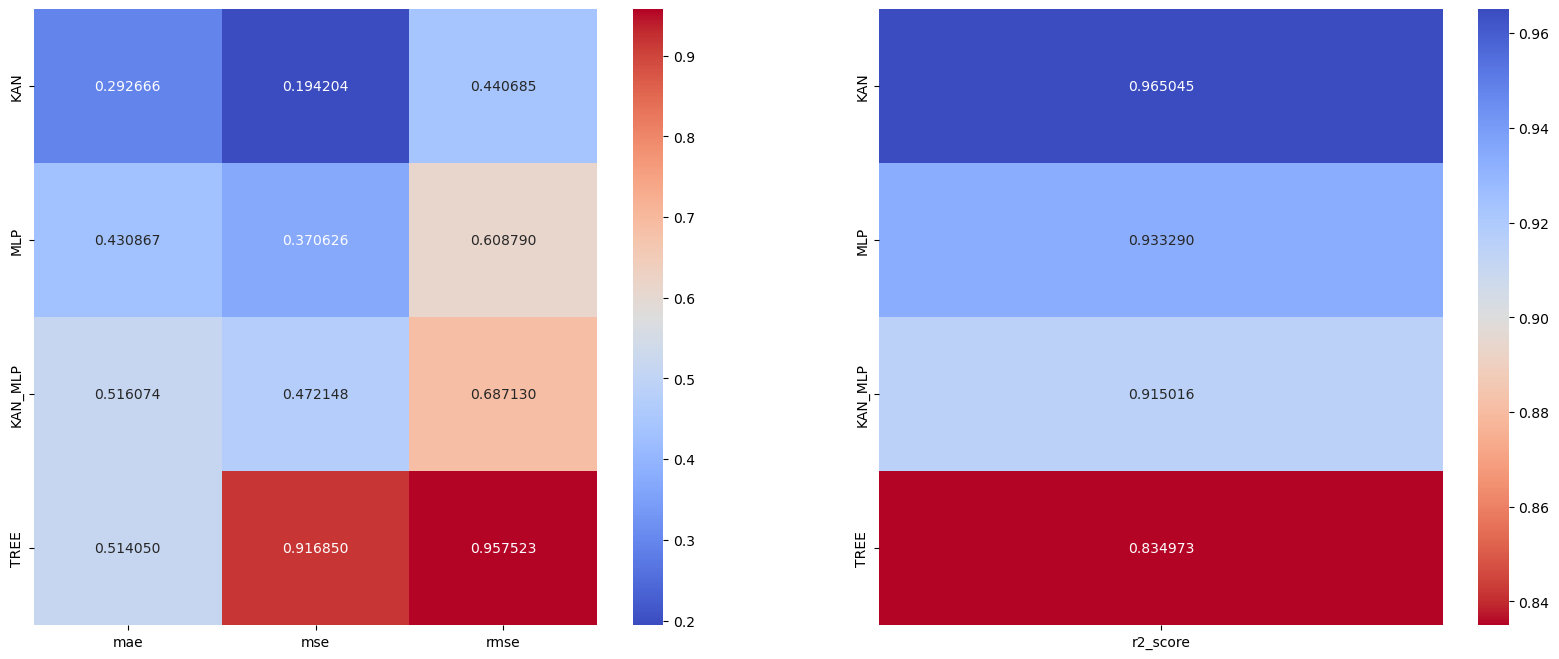

In [66]:
performance = {metric: [] for metric in list(METRICS_NAME.values())[:-1]}
performance_r2 = {"r2_score": []}

# Salvataggio performance di ogni modello
for model in elenco_modelli.values():
    # Calcolo delle metriche per il modello corrente
    result_metrics = calculate_metrics(model, x_test, y_test)

    # Aggiunta delle metriche al dizionario delle performance
    for name, result in list(result_metrics.items())[:-1]:
        performance[name].append(result)
    performance_r2["r2_score"].append(result_metrics["r2_score"])

# Creazione di un DataFrame con le performance dei modelli
df_error = pd.DataFrame(performance, index=elenco_modelli.keys())
df_r2 = pd.DataFrame(performance_r2, index=elenco_modelli.keys())

# Visualizzazione della heatmap
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.heatmap(df_error, annot=True, cmap='coolwarm', fmt='.6f')  
plt.subplot(1, 2, 2)
sns.heatmap(df_r2, annot=True, cmap='coolwarm_r', fmt='.6f')  
plt.show()


Nella seguente cella confrontiamo i nostri modelli sulla base della loro "accuratezza" di predizione; qui con accuratezza, con un piccolo abuso di linguaggio dalla terminologia della classificazione, intendiamo il confronto tra il numero di predizioni corrette e il numero di predizioni errate dei modelli.

Trattandosi di un task di regressione si potrebbe anche introdurre un certo margine di tolleranza considerando predizioni corrette anche quelle che si discostano entro un certo range dal valore target (ad esempio, nel nostro caso, avremmo potuto considerare corrette predizioni con un giorno in più o in meno di differenza dal ground truth).
Abbiamo tuttavia preferito seguire un approccio più rigido, anche considerando la delicatezza dell'ambito di applicazione, e prendere come corrette solo le predizioni che, a seguito dell'arrotondamento, sono identiche al target.

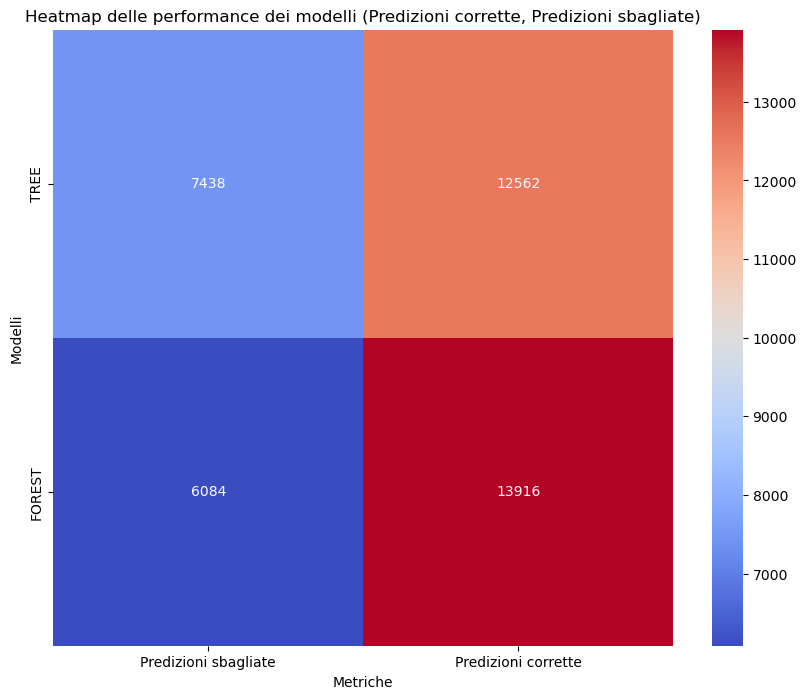

In [14]:
# Definizione funzione per calcolo dell'errore delle predizioni
def calculate_error_prediction(model, X, y):
    rounded_predictions = np.round(model.predict(X).reshape(-1)).astype(int)
    boolean_array_result = y.numpy() == rounded_predictions
    count_elements = np.unique(boolean_array_result, return_counts=True)
    count_elements = dict(np.transpose(count_elements))

    return {'Predizioni sbagliate': count_elements[0], 'Predizioni corrette': count_elements[1]}

# Inizializzazione del dizionario delle performance
performance = {'Predizioni sbagliate': [], 'Predizioni corrette': []}

for model in elenco_modelli.values():
    # Calcolo delle metriche di errore per il modello corrente
    result_predictions = calculate_error_prediction(model, x_test, y_test)

    # Aggiunta delle metriche al dizionario delle performance
    for name, result in result_predictions.items():
        performance[name].append(result)

# Creazione di un DataFrame con le performance dei modelli
df_ = pd.DataFrame(performance, index=elenco_modelli.keys())

# Visualizzazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_, annot=True, cmap='coolwarm', fmt='d')
plt.title("Heatmap delle performance dei modelli (Predizioni corrette, Predizioni sbagliate)")
plt.xlabel("Metriche")
plt.ylabel("Modelli")
plt.show()

# Prestazione dei modelli di apprendimento automatico
Effettuiamo ora un confronto tra i modelli di apprendimento automatico e vediamo in che modo le metriche che stiamo monitorando vengono ottimizzate al passare delle epoche di addestramento.

Abbiamo deciso di visualizzare i grafici utilizzando una **scala logaritmica** sull'asse verticale, questa infatti ci permette di evidenziare al meglio le fluttuazioni delle metriche dunque di farci un'idea grafica circa la stabilità dei modelli.

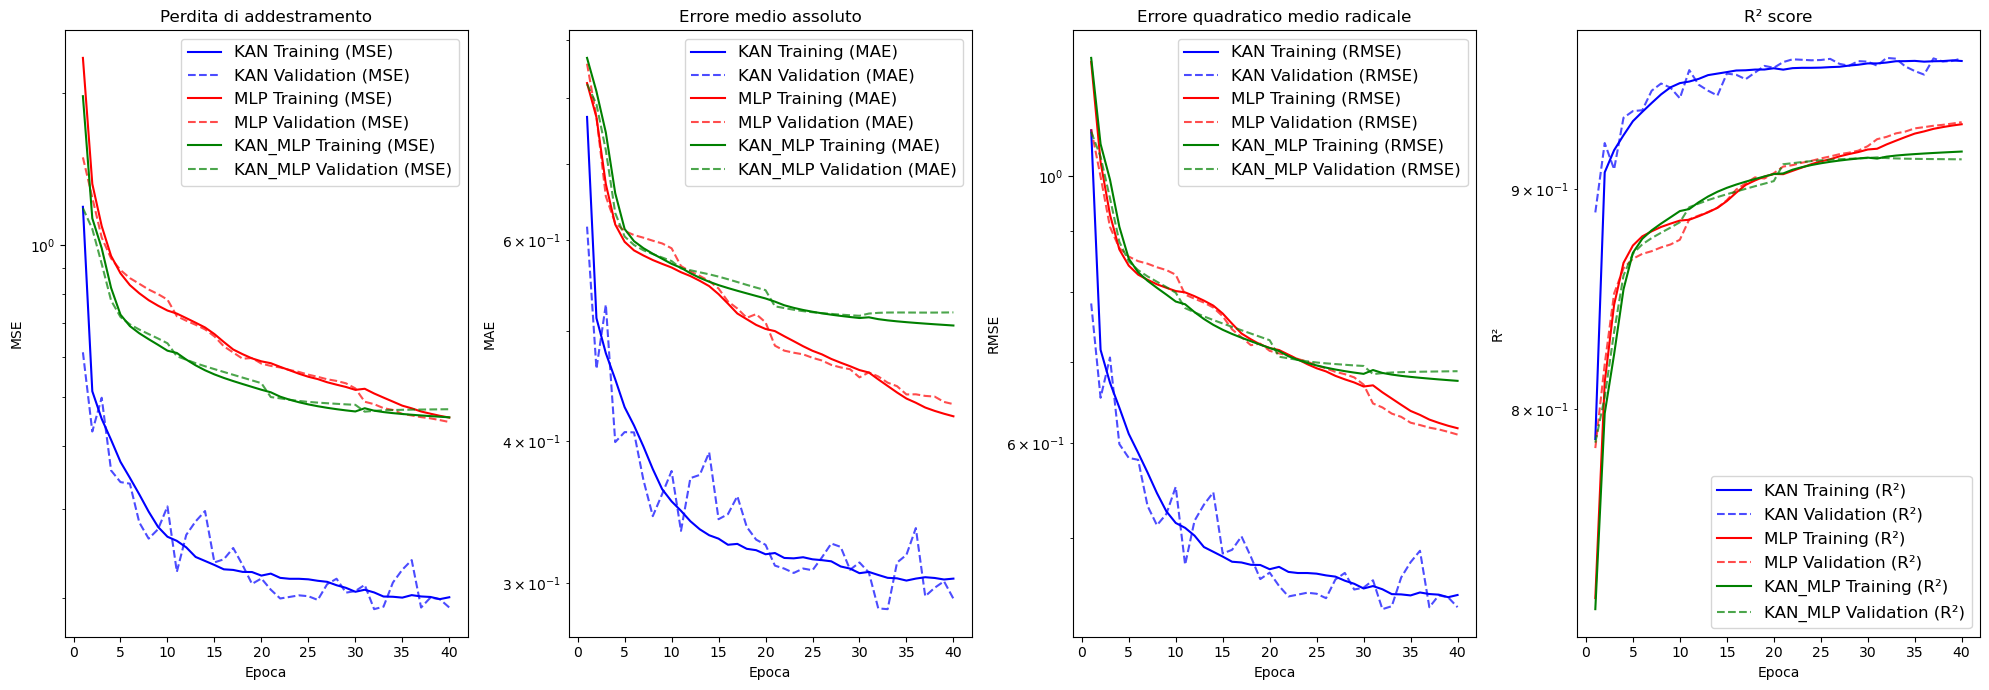

In [42]:
# Definizione funzione di creazione linechart
def plot_data(ax, epochs, metric, val_metric, model_name, metric_name, color):
    ax.plot(epochs, metric, color, label=f'{model_name} Training ({metric_name})') 
    ax.plot(epochs, val_metric, color+'--', alpha=0.7, label=f'{model_name} Validation ({metric_name})') 
    ax.set_xlabel('Epoca')
    ax.legend(fontsize='large')

plt.figure(figsize=(20, 7))


# Crea subplot per ogni metrica
ax1 = plt.subplot(1, 4, 1)
ax1.set_title('Perdita di addestramento')
ax1.set_ylabel('MSE')
ax1.set_yscale('log')

ax2 = plt.subplot(1, 4, 2)
ax2.set_title('Errore medio assoluto')
ax2.set_ylabel('MAE')
ax2.set_yscale('log')

ax3 = plt.subplot(1, 4, 3)
ax3.set_title('Errore quadratico medio radicale')
ax3.set_ylabel('RMSE')
ax3.set_yscale('log')

ax4 = plt.subplot(1, 4, 4)
ax4.set_title('R² score')
ax4.set_ylabel('R²')
ax4.set_yscale('log')

# Per ogni modello associato al suo colore
for (model_name, history), color in zip(histories.items(), COLORS):

    # Salvataggio performance
    loss, val_loss, mae, val_mae, rmse, val_rmse, r2_score, val_r2_score = history['loss'], history['val_loss'], history['mae'], history['val_mae'], history['rmse'], history['val_rmse'], history['r2_score'], history['val_r2_score']

    # Calcolo numero di epoche 
    epochs = range(1, len(loss) + 1)

    # Creazione 3 plot con performance di train e validation al variare delle epoche
    plot_data(ax1, epochs, loss, val_loss, model_name, 'MSE', color)
    plot_data(ax2, epochs, mae, val_mae, model_name, 'MAE', color)
    plot_data(ax3, epochs, rmse, val_rmse, model_name, 'RMSE', color)
    plot_data(ax4, epochs, r2_score, val_r2_score, model_name, 'R²', color)

plt.tight_layout()
plt.show()


# Analisi equità di genere

Dopo aver valutato i nostri modelli dal punto di vista prestazionale, ora considereremo l'aspetto dell'**equità algoritmica**.

Confrontiamo i modelli sulle solite metriche, questa volta distinguendo i record in base all'attributo **gender** (che nel nostro caso assume due valori). 

I modelli più equi (dunque preferibili sul piano dell'eqità algoritmica) avranno prestazioni simili per entrambe le categorie considerate.

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'KAN': {0.0: dict_values([0.28454646468162537, 0.18267489969730377, 0.42740485072135925, 0.9661989212036133]), 1.0: dict_values([0.3036077320575714, 0.20974098145961761, 0.4579748809337616, 0.9631083607673645])}, 'MLP': {0.0: dict_values([0.42739221453666687, 0.3588925004005432, 0.5990763902664185, 0.9335926175117493]), 1.0: dict_values([0.4355487525463104, 0.3864387571811676, 0.621641993522644, 0.9320287108421326])}, 'KAN_MLP': {0.0: dict_values([0.5073907971382141, 0.45537400245666504, 0.6748140454292297, 0.9157402515411377]), 1.0: dict_values([0.5277761816978455, 0.49475380778312683, 0.7033873796463013, 0.9129769802093506])}, 'TREE': {0.0: dict_values([0.49943384528160095, 0.882849931716919, 0.939600944519043, 0.8366425633430481]), 1.0:

IndexError: Inconsistent shape between the condition and the input (got (8, 1) and (8,))

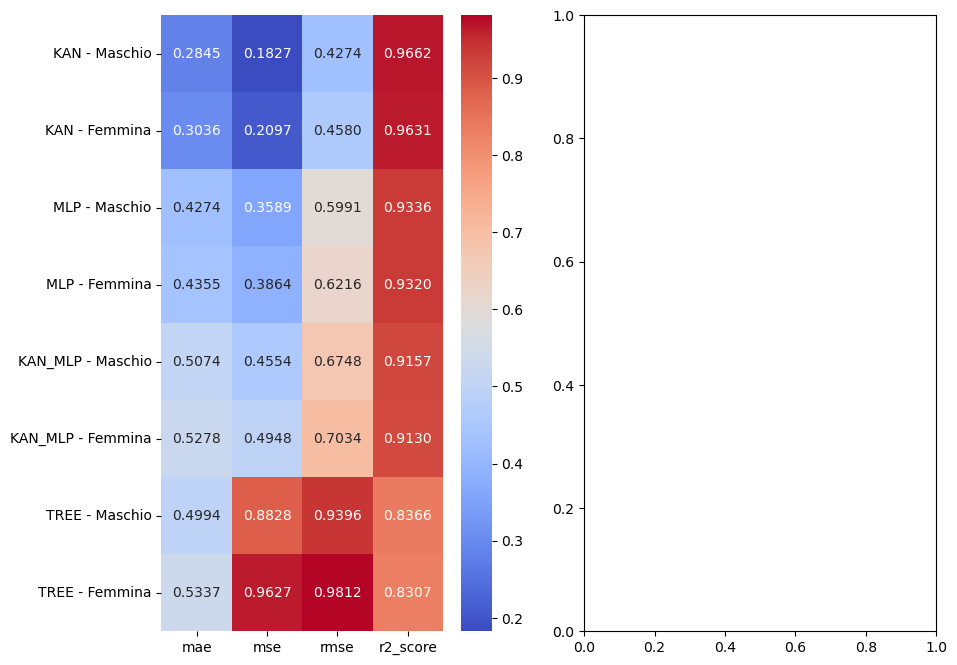

In [80]:
# Definizione delle categorie e sottogruppi
CATEGORY = 'gender'
INDEX_CATEGORY = FEATURES.index(CATEGORY)
SUBGROUPS = df[CATEGORY].unique()


# Creazione di un dizionario per memorizzare i risultati
all_results = {}

for model_name, model in elenco_modelli.items():
    results = {}

    for sg in SUBGROUPS: 
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, INDEX_CATEGORY] == sg #crea una maschera booleana
        features1 = x_test[subgroup_indices] #salva i record relativi al sottogruppo corrente
        labels = y_test[subgroup_indices]  #salva le label relative al sottogruppo corrente
        
        # Calcolo delle metriche per ciascun sottogruppo
        results[sg] = calculate_metrics(model, features1, labels).values()

    all_results[model_name] = results
print(all_results)

# Creazione Dataframe performance
df_ = pd.DataFrame()

for model_name, results in all_results.items():

    # Definizone dataframe di un modello
    temp_df = pd.DataFrame(results, index=METRICS_NAME.values())

    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']

    # Concatenazione dataframe di un modello ai precedenti
    df_ = pd.concat([df_, temp_df], axis=1)

df_r2 = df_.loc["r2_score"]
# Processamento del dataset
df_ = df_.astype(float)
df_ = df_.transpose()
df_r2 = df_r2.transpose()

# Visualizzazione della heatmap
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.heatmap(df_, annot=True, cmap='coolwarm', fmt=".4f")
plt.subplot(1,2,2)
sns.heatmap(df_r2, annot=True, cmap='coolwarm_r', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()

# Trasparenza algoritmica
Tra gli obiettivi principali del nostro progetto c'è quello di valutare se e in che misura le KAN possano introdurre dei miglioramenti nella **trasparenza algoritmica**.

Si tratta di un aspetto fondamentale in particolare su applicazioni che utilizzano dati sensibili come la nostra, per le quali non sarebbero accettabili elaborazioni di tipo black-box.

Per studiare la spiegabilità abbiamo utilizzato tre metodi:

- Feature importance
- LIME (Local Interpretable Model-agnostic Explanations)
- Grafo di rappresentazione dei livelli

I primi due sono **agnostici** cioè applicabili a qualsiasi modello, il terzo è invece specifico per l'architettura delle KAN.

## Feature importance

Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.

In [18]:
# Calcola feature importance del modello
def calculate_feature_importance(model, X, y):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
        importance = results.importances_mean

    # Ritorna un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(FEATURES, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per ogni modello
caratteristiche = []
for nome, modello in elenco_modelli.items():
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
625/625 ━━━

In [19]:
importanze = {}

for nome_modello, importanza_caratteristiche in caratteristiche:
    importanze[nome_modello] = {}

    # Stampa il nome del modello
    print(f"\nModello: {nome_modello}")
    
    # Calcola totale delle importanze
    totale = sum(abs(imp) for imp in importanza_caratteristiche.values())
    
    # Stampa le caratteristice e la loro importanza normalizzata
    for caratteristica, importanza in importanza_caratteristiche.items():
        importanze[nome_modello][caratteristica] = importanza / totale
        print(f"Caratteristica: {caratteristica}, Importanza: {importanza:.2f}, Importanza nortmalizzata: {((importanza / totale)):.2f}")
        


 Modello: MLP
Caratteristica: vdate, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: rcount, Importanza: 6.64, Importanza nortmalizzata: 0.66
Caratteristica: gender, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: dialysis, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: asthma, Importanza: 0.11, Importanza nortmalizzata: 0.01
Caratteristica: irondef, Importanza: 0.23, Importanza nortmalizzata: 0.02
Caratteristica: pneum, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: subdep, Importanza: 0.19, Importanza nortmalizzata: 0.02
Caratteristica: psychmaj, Importanza: 0.69, Importanza nortmalizzata: 0.07
Caratteristica: depress, Importanza: 0.11, Importanza nortmalizzata: 0.01
Caratteristica: psychother, Importanza: 0.12, Importanza nortmalizzata: 0.01
Caratteristica: fibrosis, Importanza: 0.02, Importanza nortmalizzata: 0.00
Caratteristica: malnutr, Importanza: 0.11, Importanza nortmalizzata: 0.01
Caratteristica: hemo, Imp

Visualizziamo graficamente i risultati di Feature importance: qui la visualizzazione più appropriata è sicuramente il barchart multiplo.

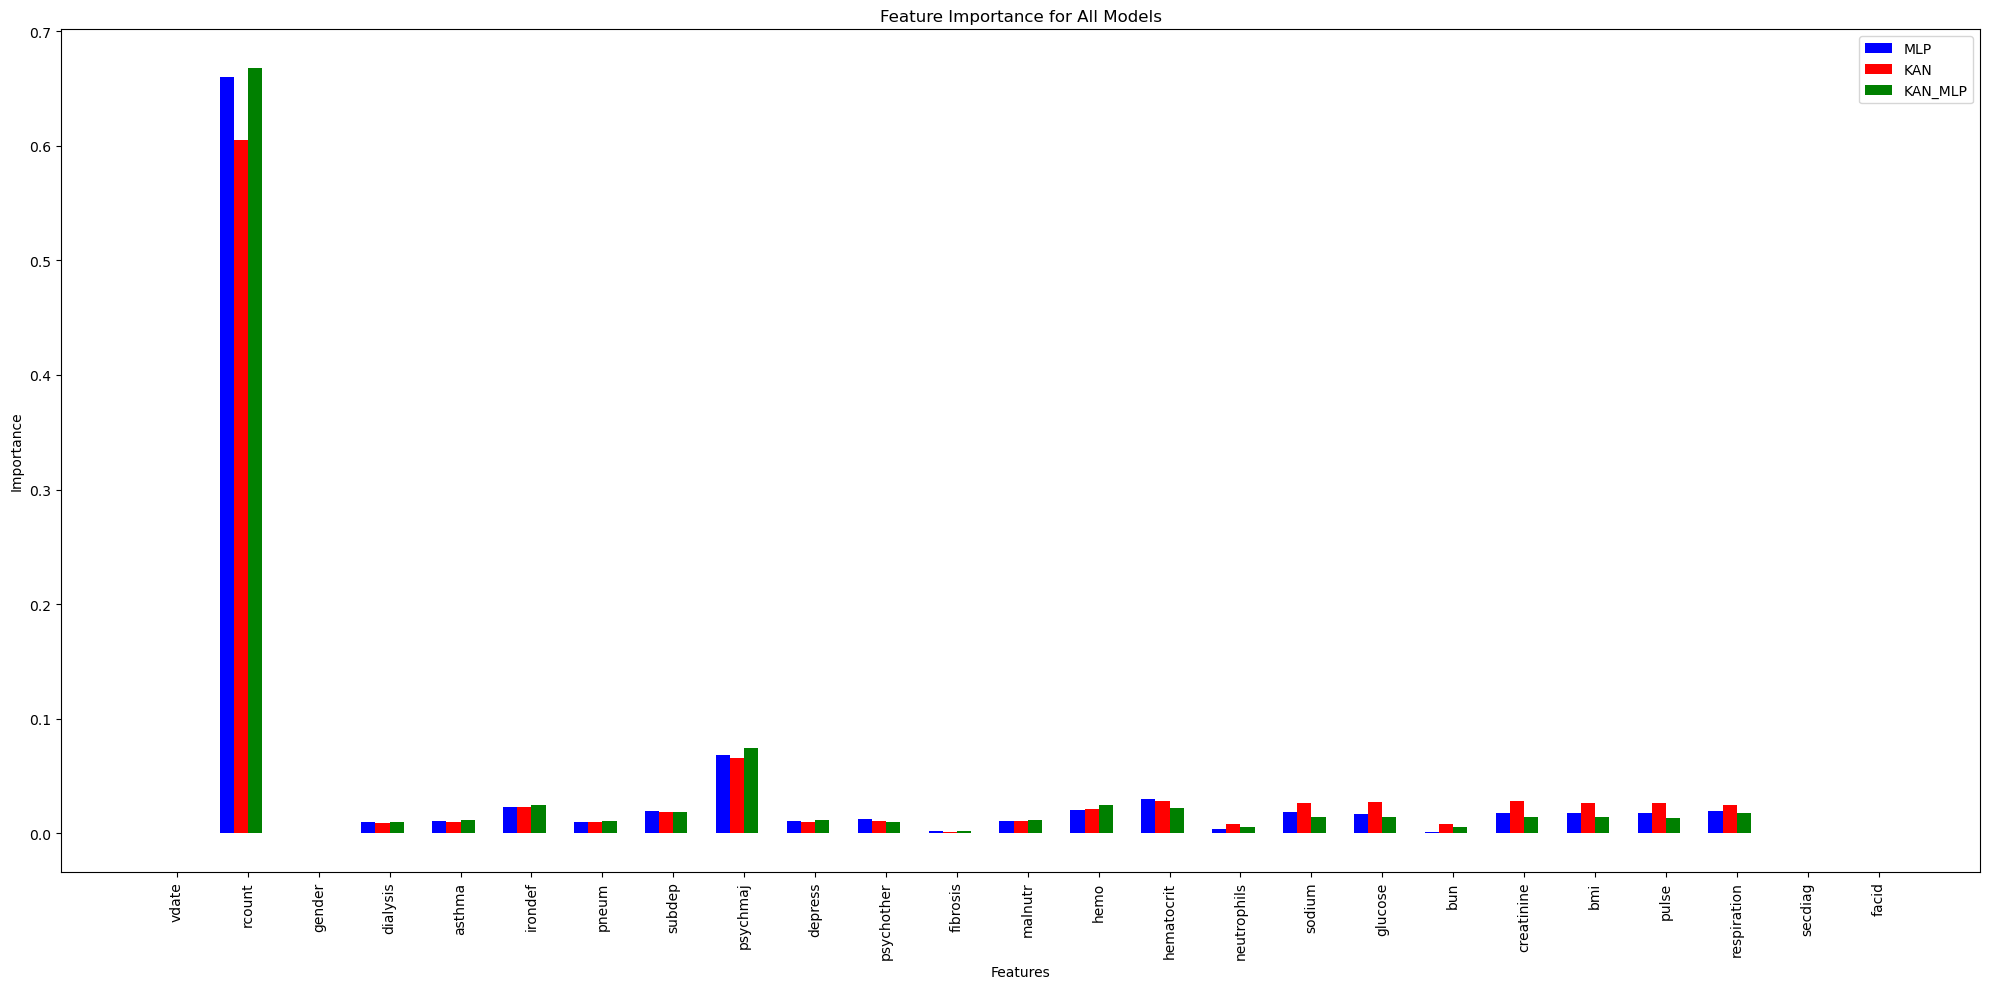

In [31]:
# Crea i ticks per l'asse x
xticks = np.arange(N_FEATURES)

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))

# Calcola la larghezza delle barre in base al numero di modelli
BAR_WIDTH = 0.6
bar_width = BAR_WIDTH / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello di un certo colore
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(xticks - BAR_WIDTH/2 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=COLORS[i % len(COLORS)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(xticks)
ax.set_xticklabels(FEATURES, rotation=90)
ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

Si nota subito come tutti i modelli utilizzino l'attributo **rcount** in maniera determinante e gli altri attributi in misura comparativamente molto minore.

Questo fatto si poteva già intravedere con la visualizzazione dell'albero decisionale, il quale utilizzava il suddetto attributo per diversi split iniziali.

# LIME

Il metodo LIME (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le predizioni di modelli complessi **su singole istanze** tramite modelli interpretabili e locali. 

LIME perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, costruisce un modello interpretabile (ad esempio, un regressore lineare) con cui effettua le predizioni sui record nell'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni mediante l'approssimazione con un modello più semplice.

Valore reale: 6.0


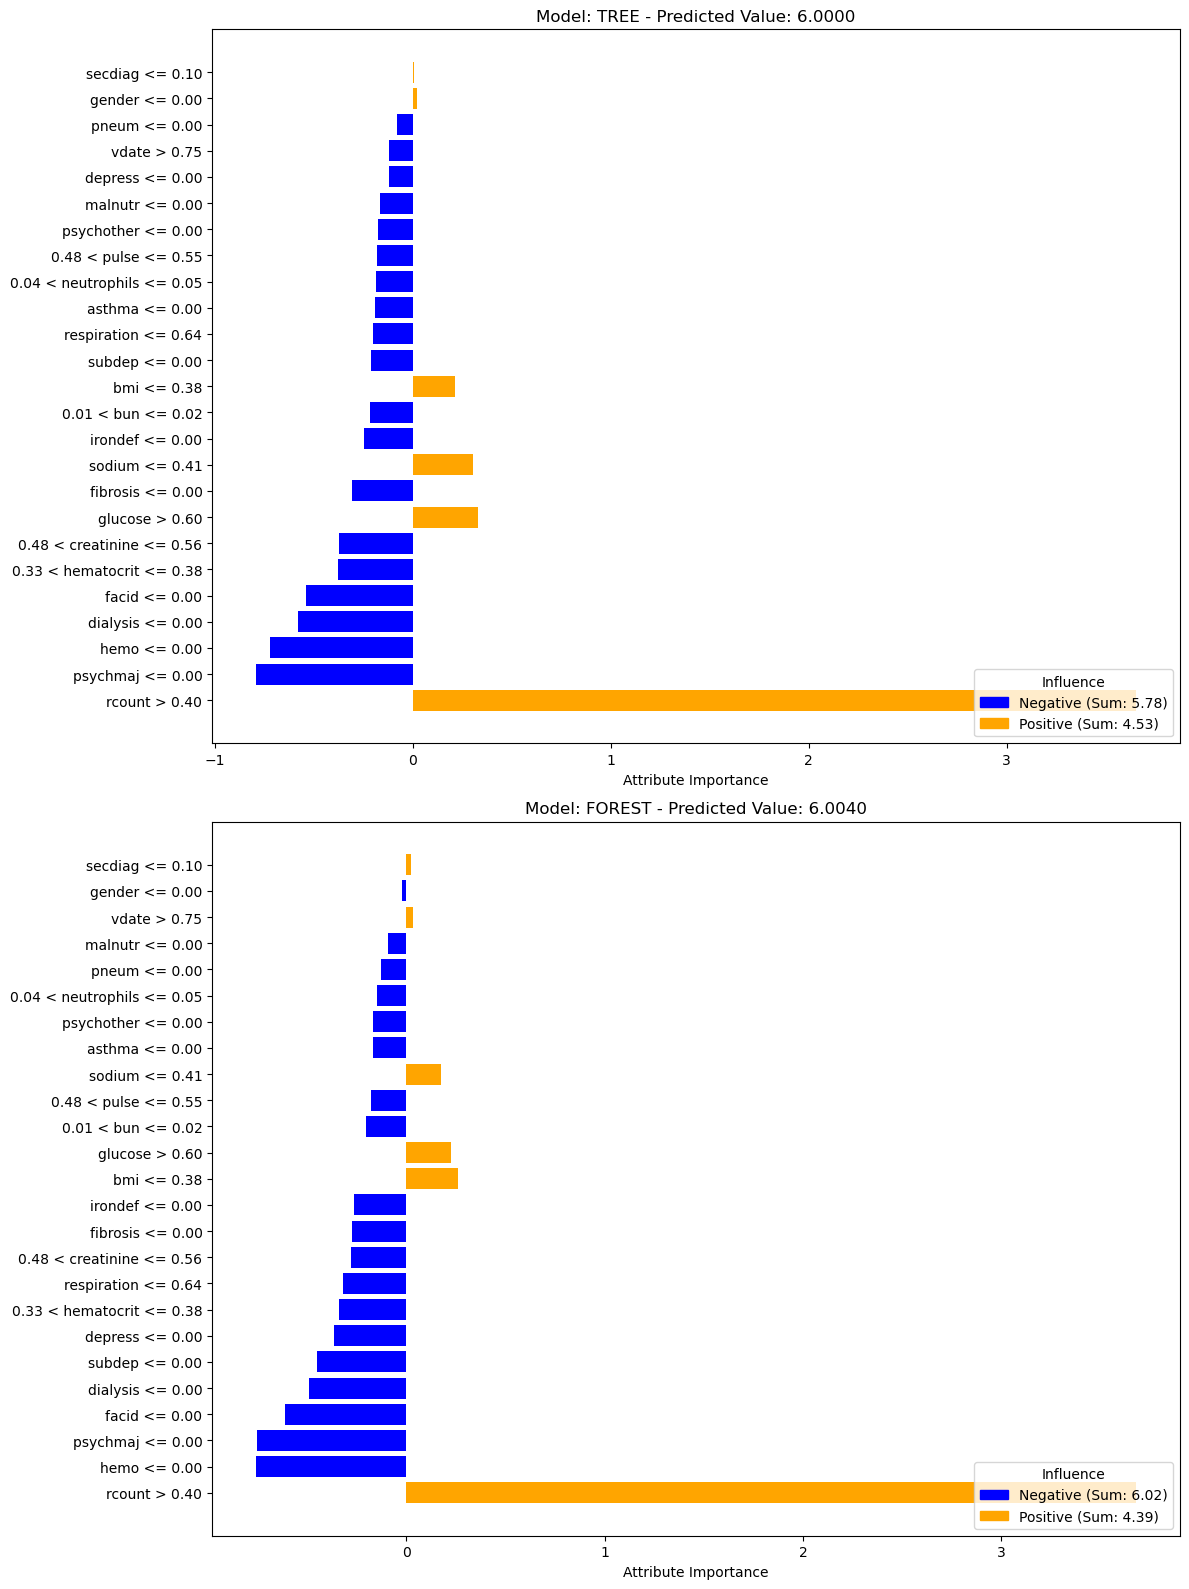

In [21]:
# Conversione di x_train e x_test in array numpy
X_train_np = x_train.numpy()
X_test_np = x_test.numpy()

# Creazione di un oggetto LimeTabularExplainer
explainer = LimeTabularExplainer(
    X_train_np,
    feature_names=FEATURES,
    class_names=['target'],
    mode='regression'
)

# Creazione di una figura con un subplot per ogni modello
fig, axs = plt.subplots(len(elenco_modelli), 1, figsize=(12, 8*len(elenco_modelli)), squeeze=False)

# Seleziona un'istanza casuale
index_selected = random.randint(0, len(X_test_np)-1)
instance = X_test_np[index_selected]
print(f"Valore reale: {y_test[index_selected].numpy()}")

# Per ogni modello dell'istanza selezionata con LIME
for i, (model_name, model) in enumerate(elenco_modelli.items()):

    explanation = explainer.explain_instance(
        instance, 
        lambda x: model.predict(tf.convert_to_tensor(x.reshape(-1, x_train.shape[1]))),
        num_features=N_FEATURES
    )
    
    # Estrazione degli attributi e delle importanze
    attributi, importances = zip(*explanation.as_list())

    colors = ['blue' if imp < 0 else 'orange' for imp in importances]
    
    # Creazione di un barplot per le importanze
    ax = axs[i, 0]
    ax.barh(range(N_FEATURES), importances, color=colors)
    ax.set_yticks(range(N_FEATURES))
    ax.set_yticklabels(attributi)
    ax.set_xlabel('Attribute Importance')
    
    # Calcolo della previsione del modello sull'istanza selezionata
    predicted_value = model.predict(tf.convert_to_tensor(instance.reshape(1, -1)))

    predicted_value_str = ', '.join(f'{v:.4f}' for v in np.atleast_1d(predicted_value.flatten()))
    
    # Impostazione del titolo del subplot
    ax.set_title(f'Model: {model_name} - Predicted Value: {predicted_value_str}')
    ax.set_facecolor('white')
    
    # Calcolo della somma delle importanze positive e negative
    positive_sum = sum(imp for imp in importances if imp > 0)
    negative_sum = abs(sum(imp for imp in importances if imp < 0))
    
    # Aggiunta di una leggenda con le somme delle importanze
    ax.legend(
        [plt.Rectangle((0,0),1,1, color=c) for c in ['blue', 'orange']],
        [f'Negative (Sum: {negative_sum:.2f})', f'Positive (Sum: {positive_sum:.2f})'],
        title='Influence', loc='lower right'
    )

# Visualizzazione del grafico
plt.tight_layout()
plt.show()



## Grafo di Architettura della KAN
Questo approccio, già utilizzato dagli autori dell'articolo introduttivo alle KAN, permette di visualizzare i grafici delle funzioni spline ai **nodi** della rete.

Si ricorda che al nodo $n$ della rete corrisponde la funzione $$l_n = \sum_{i_{0}=1}^{units_{l-1}}{\phi_{n,i_0}}$$

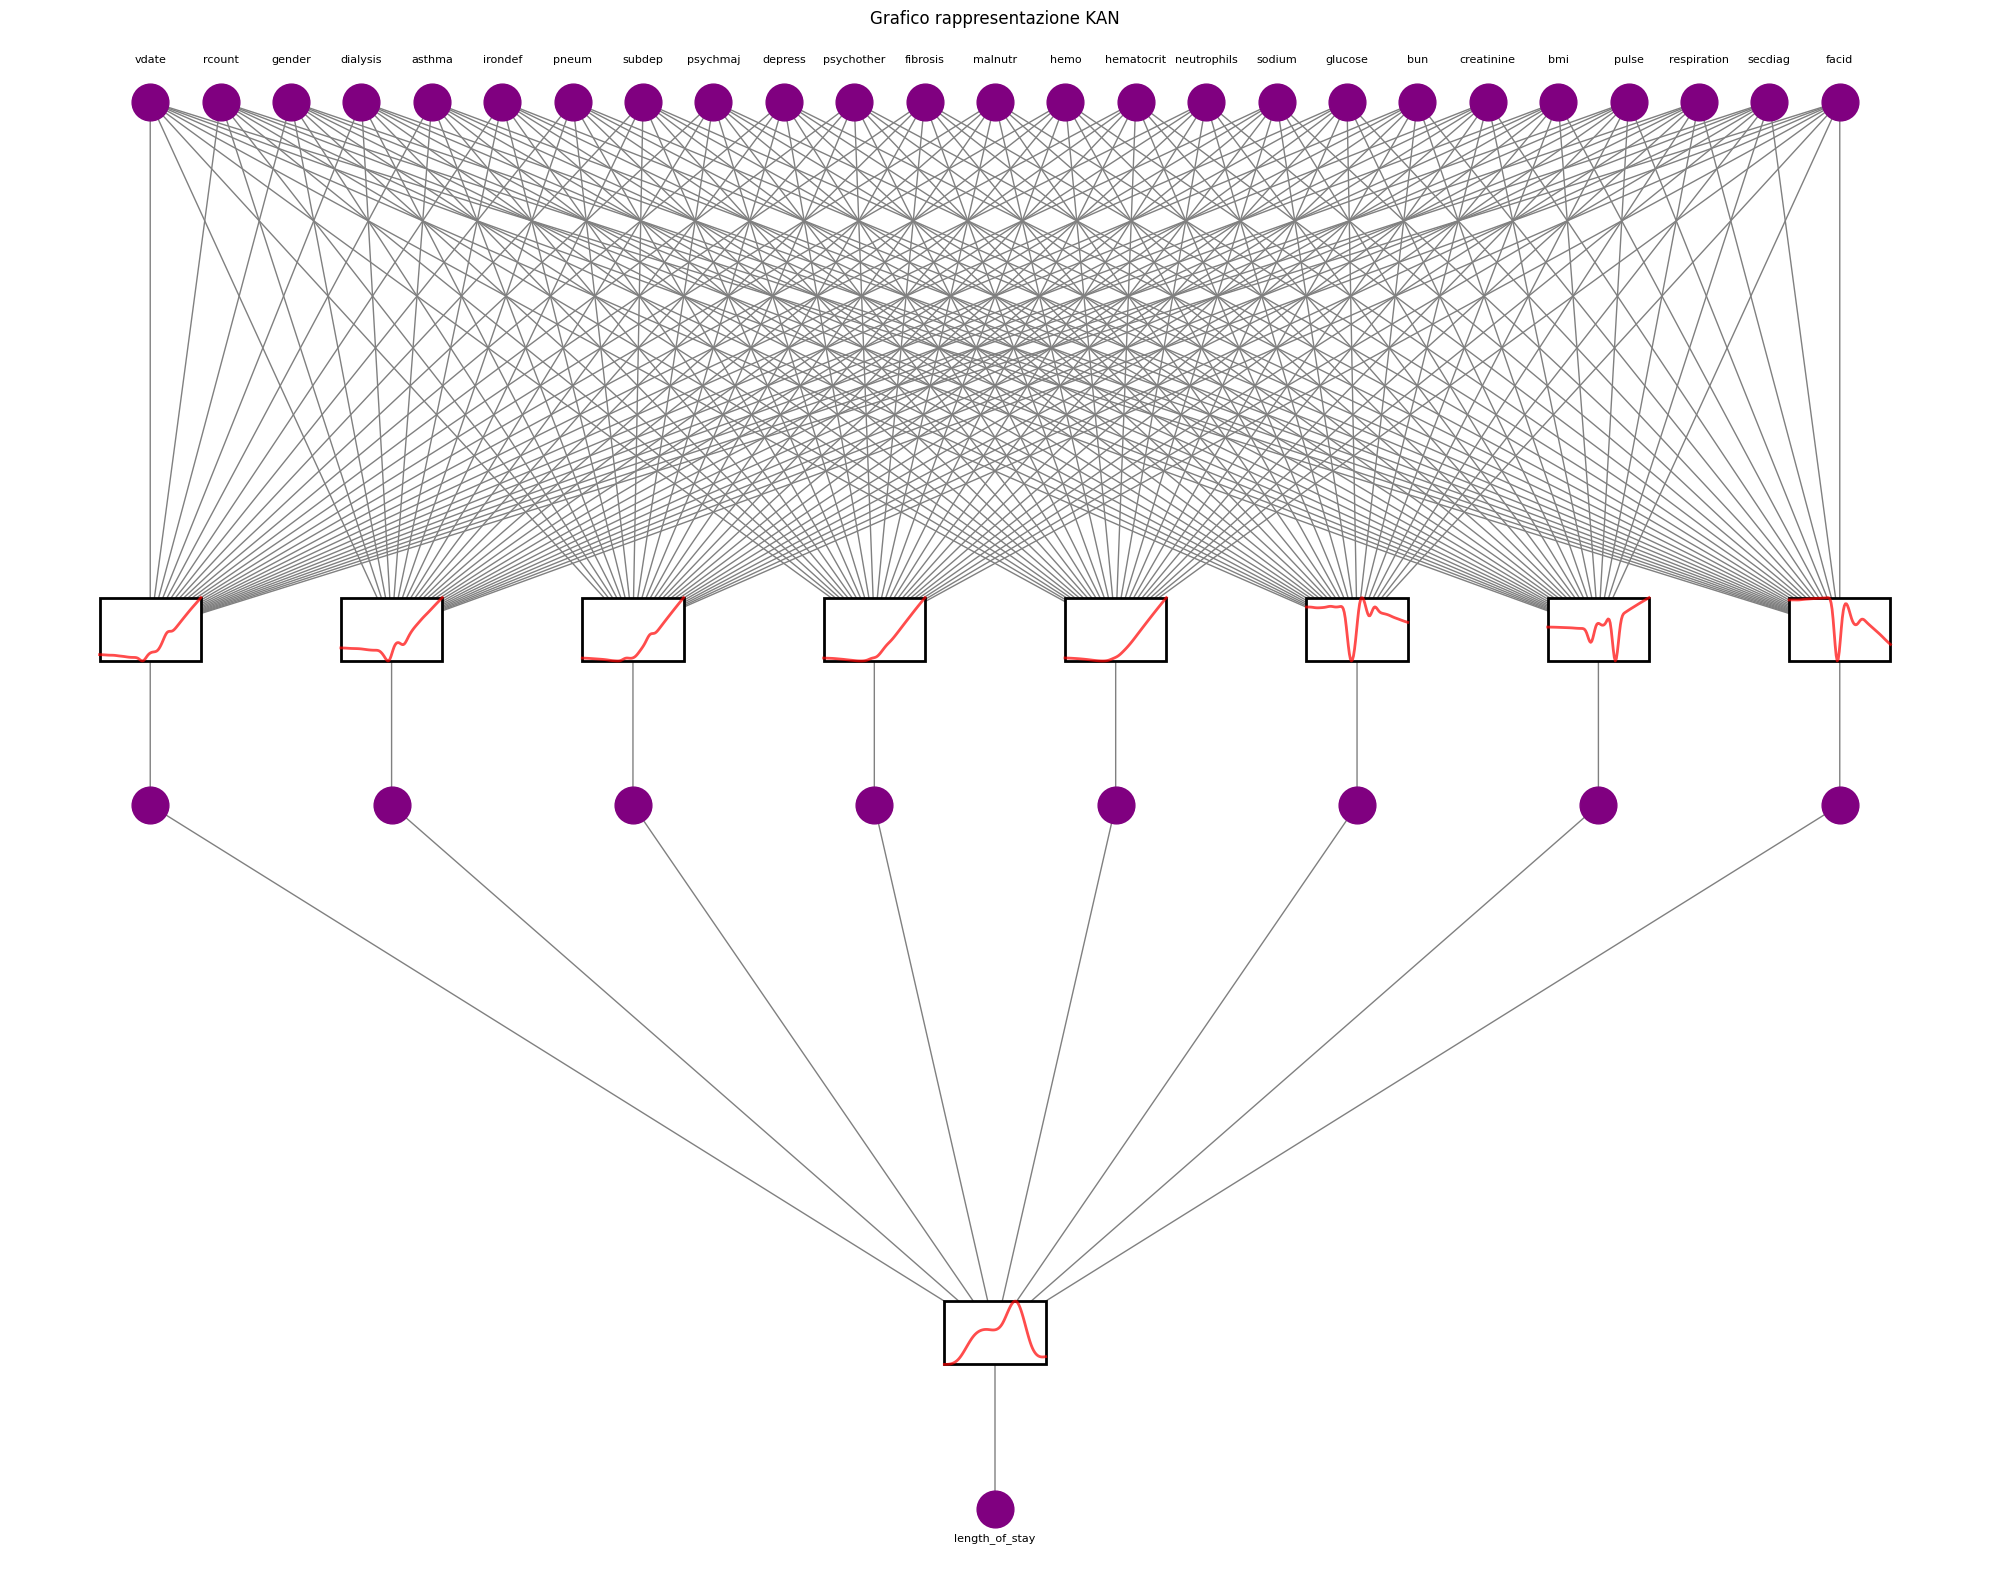

In [173]:
# Definizione della funzione 'get_all_splines_from_model' che estrae tutte le spline da un modello
def get_all_splines_from_model(model):
    all_splines = []

    # Estrae splines di ogni KAN
    for layer in model.layers:
        if isinstance(layer, DenseKAN):
            splines = layer.get_spline_list()
            all_splines.append(splines)
            
    return all_splines

# Definizione della funzione 'create_kan_tree_from_model' che crea un grafo da un modello
def create_kan_tree_from_model(model, features):
    # Creazione di un grafo diretto
    G = nx.DiGraph()
    
    # Aggiunta dei nodi di input al grafo
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiunta dei layer nascosti e di output al grafo
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")

    return G

# Definizione della funzione 'draw_merged_edges' che disegna gli archi e le spline nel grafo
def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    # Inizializzazione di una lista vuota per contenere i punti di fusione
    merge_points = []
    # Per ogni nodo nel grafo
    for target in G.nodes():
        # Ottiene la lista degli archi entranti nel nodo
        in_edges = list(G.in_edges(target))
        # Se ci sono più di un arco entrante
        if len(in_edges) > 1:
            # Calcola la posizione del punto di fusione
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            # Aggiunge il punto di fusione alla lista dei punti di fusione
            merge_points.append(merge_point)
            
            # Per ogni arco entrante
            for source, _ in in_edges:
                # Calcola la posizione di partenza dell'arco
                start = np.array(pos[source])
                # Disegna l'arco dal punto di partenza al punto di fusione
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            # Disegna un arco dal punto di fusione al nodo
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    # Ottiene tutte le spline dal modello
    spline_collection = get_all_splines_from_model(kan)
    sum_of_spline = []
    knots_list = []

    # Prende le liste delle spline di cui fare la somma
    for spline_model in spline_collection:
        for i in range(len(spline_model[0])):
            knots_list.append(spline_model[0][0].t)
            list_splines = [spline_model[j][i] for j in range(len(spline_model))]
            sum_of_spline.append(list_splines)

    square_size = 0.06  # Dimensione fissa del quadrato
    # Per ogni punto di fusione
    for i, point in enumerate(merge_points):
        # Se c'è una spline corrispondente al punto di fusione
        if i < len(sum_of_spline):
            # Disegna un rettagolo attorno al punto di fusione
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Calcola la somma delle spline entranti in un nodo
            spl = sum_of_spline[i]
            xx = np.linspace(knots_list[i][0, 0], knots_list[i][0, -1], 100) 
            yy = 0
            for s in spl:
                yy += s(xx)
            
            # Normalizza i valori della spline per adattarsi al quadrato
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            # Disegna la spline normalizzata
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    return merge_points


# Crea un grafo dal modello
G = create_kan_tree_from_model(kan, FEATURES)

# Imposta il grafico
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Disegna gli archi e i quadrati con le spline nel grafo
merge_points = draw_merged_edges(G, pos, ax, kan)

# Disegna i nodi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Imposta l'ordine di sovrapposizione per i nodi

# Aggiunge le etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Aggiunge l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

# Imposta il titolo del grafico
plt.title("Grafico rappresentazione KAN")
# Nasconde gli assi
plt.axis('off')
# Ridimensiona il layout del grafico
plt.tight_layout()
# Mostra il grafico
plt.show()